In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

## Load image from skimage

In [3]:
img = data.astronaut()
[m,n] = img.shape[0:2]
n_pixels = m*n

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning:

The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder. Note that this pipeline is not the most efficient for image segmentation. This pipeline uses only colour and position cues. Our objective is to demonstrate how effective local graph clustering is.

In [4]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,0.4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

## Load the matrix in the LocalGraphClustering API

In [5]:
g = GraphLocal()
g.from_sparse_adjacency(A)

## Find a single segment in the image using local graph clustering. Ignore warnings about weighted graphs.

0.03919816017150879


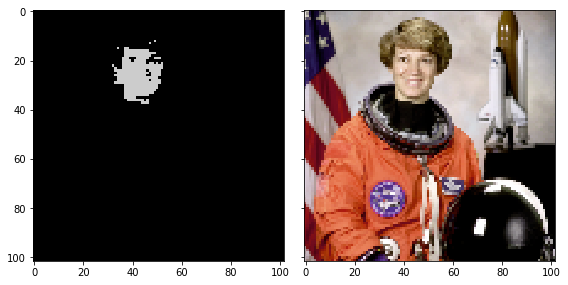

In [19]:
start = time.time()
refnode = [120*m + 220]
output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=0.03,rho=1.0e-15,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000,cpp=True) 
end = time.time()
print(end - start)

labels = np.zeros(n_pixels)
labels[output[0]] = 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(labels.reshape((m,n)), cmap='nipy_spectral')
ax[1].imshow(img)

#for a in ax:
    #a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral local graph clustering.

In [32]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

1729.6063208580017


## Plot

2.471363067626953


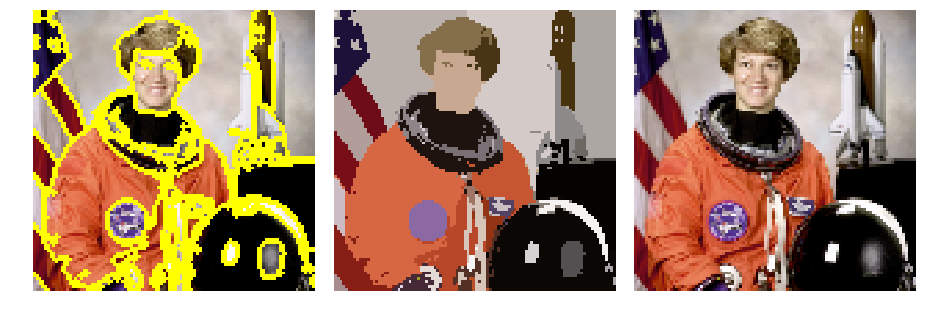

In [36]:
out_lgc = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral + flow (MQI) local graph clustering

In [8]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation_with_improve(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

495.806991815567eted:  90.045547485351565


## Visualize the result

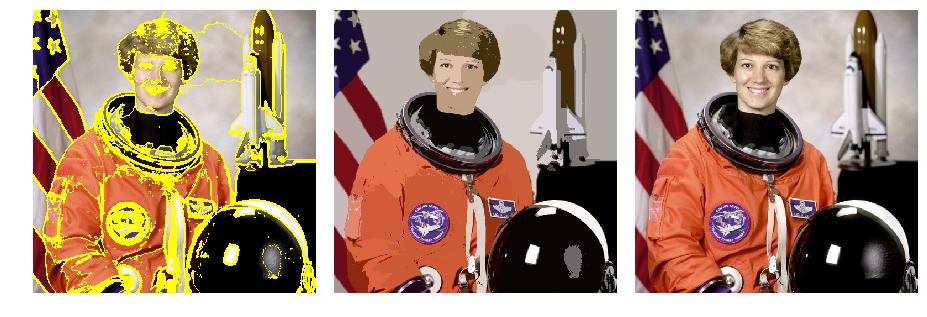

In [9]:
out_lgc_with_improve = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc_with_improve)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Run the classic normalized cut from skimage

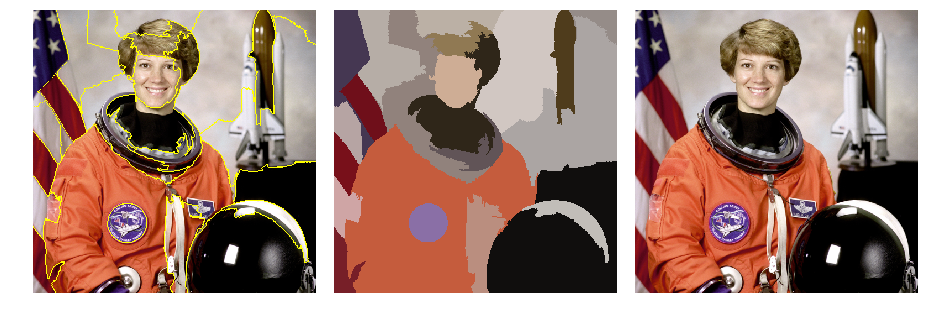

In [10]:
labels_slic = segmentation.slic(img, n_segments=100)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=0.001, num_cuts=10)
out_ncuts = color.label2rgb(new_labels_slic, img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(out_ncuts)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Slice image using slic from skimage

In [11]:
labels = segmentation.slic(img, compactness=30, n_segments=400)
out_slic = color.label2rgb(labels, img, kind='avg')

## Visualize all results

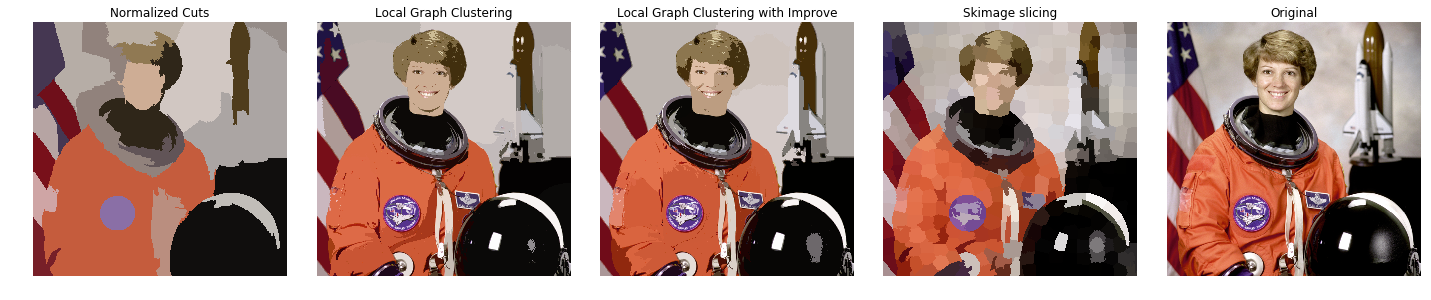

In [12]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(out_ncuts)
ax[1].imshow(out_lgc)
ax[2].imshow(out_lgc_with_improve)
ax[3].imshow(out_slic)
ax[4].imshow(img)

ax[0].set_title('Normalized Cuts')
ax[1].set_title('Local Graph Clustering')
ax[2].set_title('Local Graph Clustering with Improve')
ax[3].set_title('Skimage slicing')
ax[4].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Compute NCP plot

In [13]:
import warnings
warnings.filterwarnings('ignore')

ncp_instance = NCPData(g,store_output_clusters=True,do_largest_component=False)
ncp_instance.approxPageRank(ratio=1,nthreads=6,method = "l1reg-rand")

approxPageRank:ncpapr_l1reg-rand:  101.1 neighborhoods
approxPageRank:ncpapr_l1reg-rand:  279.7 localmin rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  434.5 localmin rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  588.2 random_node rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  743.3 random_node rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  898.9 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand: 1055.4 random_neighborhood rho=1.0e-04


## Make an interactive NCP

In [14]:
p = NCPPlots(ncp_instance)
p.cond_by_size_itrv();

## Reload the data and make sure the graph is a connected component

In [3]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,1.0e-4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

g = GraphLocal()
g.from_sparse_adjacency(A)

g.is_disconnected()

There are  108  connected components in the graph
The graph is a disconnected graph.


True

## Run spectral

/usr/local/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:119: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted or l1reg-rand instead if you want to keep the edge weights.



33.514100074768066
conductance:  0.14033766116797824
Check if output of l1reg is a connected component
There are  1  connected components in the graph
The graph is not a disconnected graph.
Minimum non-zero value in adjacency:  0.00010005190780791777
Maximum non-zero value in adjacency:  0.9806582491395386
Minimum non-zero value in sub-adjacency (based on output of l1reg):  0.00010005190780791777
Maximum non-zero value in sub-adjacency (based on output of l1reg):  0.9806582491395386


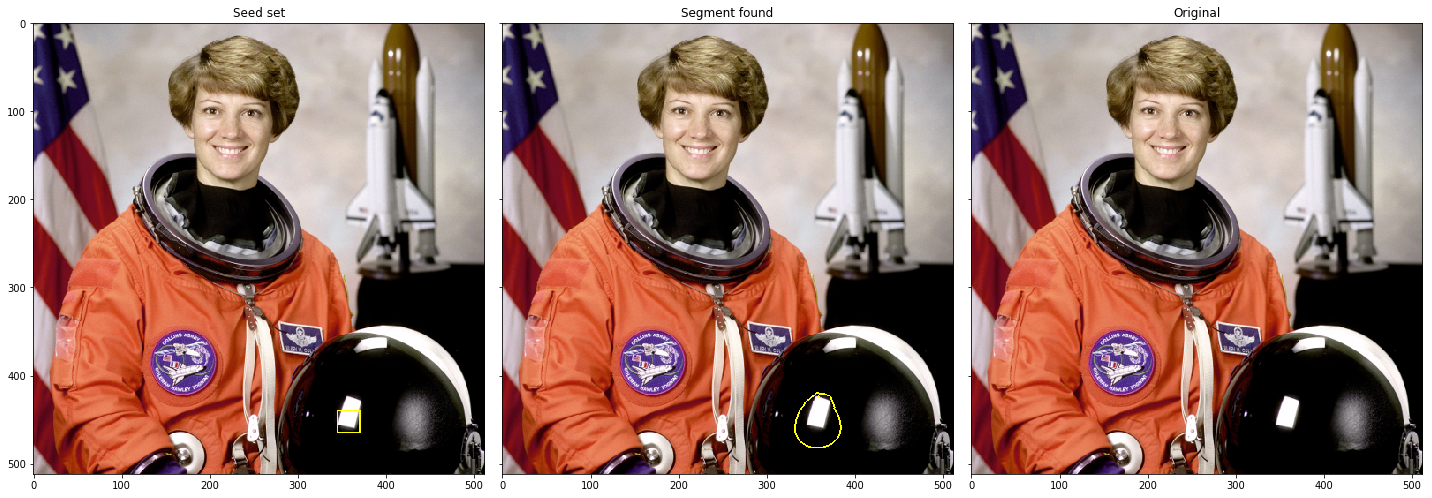

In [4]:
start = time.time()

width = 25
i = 440
j = 345

refnode = []

for p in range(i,i+width):
    
    for q in range(j,j+width):
        
        refnode.append(p*n + q)

#refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.8]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-6,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels_seed = np.zeros(n_pixels, dtype=np.int32)
labels_seed[refnode] = 1

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found')
ax[2].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(min_crit_embedding[0]))


A2 = g.adjacency_matrix.tocsr()[min_crit_embedding[0], :].tocsc()[:, min_crit_embedding[0]]
g_copy = GraphLocal()
g_copy.from_sparse_adjacency(A2)

print("Check if output of l1reg is a connected component")
g_copy.is_disconnected()

print("Minimum non-zero value in adjacency: ", A.data.min())
print("Maximum non-zero value in adjacency: ", A.data.max())

print("Minimum non-zero value in sub-adjacency (based on output of l1reg): ", A2.data.min())
print("Maximum non-zero value in sub-adjacency (based on output of l1reg): ", A2.data.max())

## Run MQI

In [5]:
output_mqi = flow_clustering(g,min_crit_embedding[0],method="mqi_weighted")

labels_mqi = np.zeros(n_pixels, dtype=np.int32)
labels_mqi[output_mqi[0]] = 1

print("Improved conductance: ", output_mqi[1])

Improved conductance:  2.5503133378052677e-07


## Visualize the results

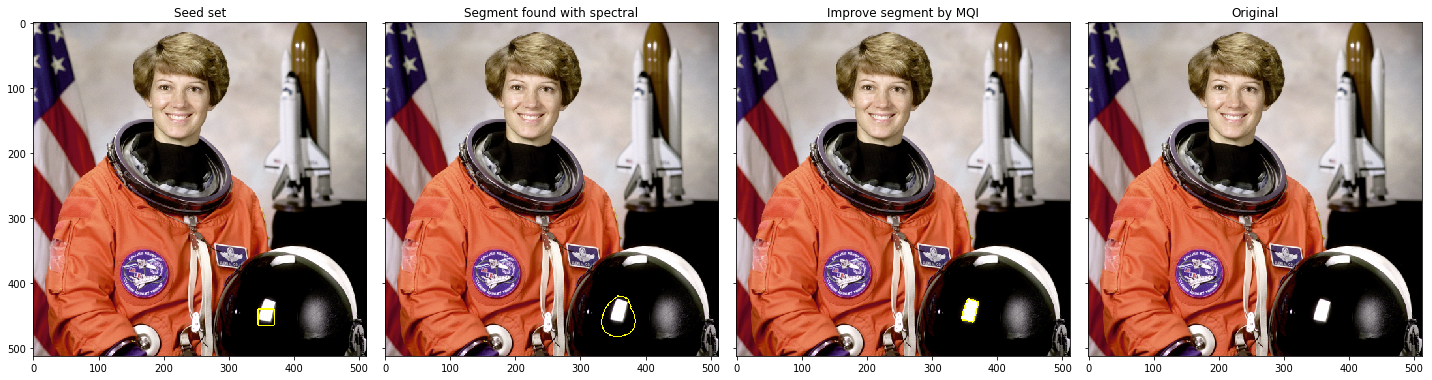

In [6]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(mark_boundaries(img, labels_mqi.reshape((m,n)),mode='thick'))
ax[3].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found with spectral')
ax[2].set_title('Improve segment by MQI')
ax[3].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

## Rerun spectral to show that MQI does not work properly

23.279839038848877
conductance:  1.194297971949422e-08


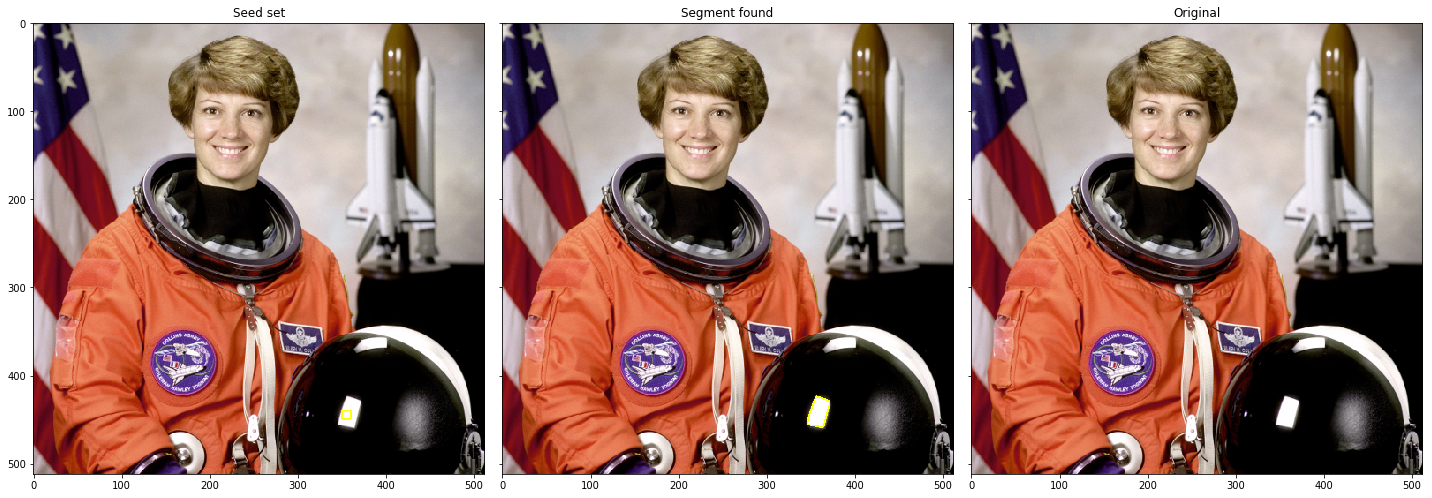

In [7]:
start = time.time()

width = 10
i = 440
j = 350

refnode = []

for p in range(i,i+width):
    
    for q in range(j,j+width):
        
        refnode.append(p*n + q)
        
#refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.8]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-7,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels_seed = np.zeros(n_pixels, dtype=np.int32)
labels_seed[refnode] = 1

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found')
ax[2].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(min_crit_embedding[0]))